# Exercise 2 

Exercise 2 includes four problems that you need to solve with programming, and by providing answers to questions. For each problem you need to modify the notebook by adding your own solutions. Remember to save and commit your changes locally, and push your changes to GitHub after each major change! Regular commits will help you to keep track of your changes (and revert them if needed). Pushing your work to GitHub will ensure that you don't lose any work in case your computer crashes (can happen!).

**Due date**

This exercise should be returned to your personal Github repository within **two weeks** after the first practical session (by Wednesday 23:59). Please notice that finishing the programming exercises can take significant amount of time (especially if you don't have yet much programming experience). Hence, **it is recommended that you start immediately working on them**.

**Start your exercise in CSC Notebooks**

Before you can start programming, you need to launch the CSC Notebook instance and clone your Exercise repository there using Git. If you need help with this, [read the documentation on the course site](https://spatial-analytics.readthedocs.io/en/latest/lessons/L1/git-basics.html).

**Hints**

If there are general questions arising from this exercise, we will add hints to the course website under [Exercise 2 description](https://spatial-analytics.readthedocs.io/en/latest/lessons/L2/exercise-2.html).

## Problem 1: Prepare and explore the data (7 points)

Next, you will study areal data describing the population distribution in Helsinki Region. The data is provided by Statistics Finland. We will obtain the data using the WFS API of Statistics Finland, which is handy because we can directly read the data into geopandas by passing a special request call to it (which we provide below). 


1. Download the data from Statistics Finland into a GeoDataFrame using the `gpd.read_file()` function

2. Create a subset of the data by selecting municipalities for Helsinki Region (i.e. "kunta" with values "091", "049", "092" and "235")

3. Reset the index using `data.reset_index(drop=True)` which will ensure that the index values in your data increase sequentially starting from 0.

3. Drop all other columns except "geometry", "pt_vakiy" and "postinumeroalue" (postal code) --> i.e. select those columns from the data (check [Geo-Python course](https://geo-python-site.readthedocs.io/en/latest/notebooks/L5/exploring-data-using-pandas.html#selecting-columns) for help).

4. Re-project the data into EPSG:3067 (EUREF-FIN)

5. Calculate the population density into a column `"pop_density_km2"` for each postal code (pop per square kilometer). Notice, that after the reprojection, the geometrical units are represented as meters.

6. Answer to following questions by adding text after the `Answer` bullet points below (use programming to find out the answers for the first two questions):

 - Which postal code area has the **highest** population density? How many people per square kilometer there are?
     - Answer: The postal code area 00500 has the highest population density with 21562.78 people per square kilometer.
     
 - Which postal code area has the **lowest** population density? How many people per square kilometer there are?
     - Answer: The postal code area 01770 has the lowest population density with 0.00 people per square kilometer.
     
 - Why is it important to use population density instead of the original population count in the analysis? Describe.
     - Answer: It is important to normalize the population with the postal code area because of the varying area sizes. Some areas are covering larger areas than others so it is very misleading to compare the population counts as they are.

7. Re-project the data back to WGS84 (EPSG:4326) and create an interactive map showing the population density in Helsinki Region. For doing the interactive map, you can use a method `data.explore("pop_density_km2"`). As a result, you should get something like below:

![Helsinki Region Population density](img/helsinki_pop_density.png)




In [1]:
import geopandas as gpd

# URL for postal code level data from Statistics Finland
url = "http://geo.stat.fi/geoserver/postialue/wfs?request=GetFeature&typename=postialue:pno_tilasto_2020&outputformat=JSON"

# YOUR CODE HERE
# Download the data from Statistics Finland into a gdf using the gpd.read_file() function
gdf = gpd.read_file(url)

# Create a subset of the data by selecting municipalities for Helsinki Region
municipalities = ['091', '049', '092', '235']
# Lets name the Helsinki Region GeoDataFrame as hr_gdf
hr_gdf = gdf[gdf['kunta'].isin(municipalities)]

# Reset the index
hr_gdf.reset_index(drop=True, inplace=True)

# Drop all other columns except "geometry", "pt_vakiy" and "postinumeroalue"
hr_gdf = hr_gdf[["geometry", "pt_vakiy", "postinumeroalue"]]

# Re-project the data into EPSG:3067 (EUREF-FIN)
hr_gdf.to_crs(crs="EPSG:3067")

# Calculate the population density into a column "pop_density_km2" for each postal code (pop per square kilometer)
hr_gdf["pop_density_km2"] = hr_gdf["pt_vakiy"]/(hr_gdf["geometry"].area/1000000)

#Which postal code area has the highest population density? How many people per square kilometer there are?
max_pop_density_area = hr_gdf.loc[hr_gdf["pop_density_km2"].idxmax(), "postinumeroalue"]
max_pop_density_value = hr_gdf.loc[hr_gdf["pop_density_km2"].idxmax(), "pop_density_km2"]
print("The postal code area {:} has the highest population density with {:.2f} people per square kilometer.".format(max_pop_density_area, max_pop_density_value))

#Which postal code area has the lowest population density? How many people per square kilometer there are?
min_pop_density_area = hr_gdf.loc[hr_gdf["pop_density_km2"].idxmin(), "postinumeroalue"]
min_pop_density_value = hr_gdf.loc[hr_gdf["pop_density_km2"].idxmin(), "pop_density_km2"]
print("The postal code area {:} has the lowest population density with {:.2f} people per square kilometer.".format(min_pop_density_area, min_pop_density_value))

#Why is it important to use population density instead of the original population count in the analysis? Describe.
#Answer:
# It is important to normalize the population with the postal code area because of the varying area sizes. Some areas are covering larger areas than others so it is very
# misleading to compare the population counts as they are.

# Re-project the data back to WGS84 (EPSG:4326) and create an interactive map showing the population density in Helsinki Region
hr_gdf.to_crs(crs="EPSG:4326")
hr_gdf.explore("pop_density_km2")


The postal code area 00500 has the highest population density with 21562.78 people per square kilometer.
The postal code area 01770 has the lowest population density with 0.00 people per square kilometer.


## Problem 2: Investigate spatial autocorrelation (8 points)

1. Create spatial weights based on how the boundaries of our postal code areas touch each other. Create the weights based on the data GeoDataFrame using Queen contiguity and store the resulting weights into a variable `w`. For creating the spatial weights, you can use the weights submodule from pysal library (see docs). If you need further information, we also recommend checking [chapter 4](https://geographicdata.science/book/notebooks/04_spatial_weights.html) from "Geographic Data Science with Python" book (Rey et al. forthcoming). 

2. Drop possible islands (for the sake of simplicity we just ignore them in the analysis). You can get the index values of the islands from the weights by calling `w.islands`. Then, reset the index of the GeoDataFrame, and recreate the weights using Queen contiguity (in a similar manner as in step 1)

3. Row standardize the weights by using `w.transform`.

4. Answer to following questions by adding text after the `Answer` bullet point, below (hint: check the lecture materials/videos):

  - Why do we need to create spatial weights? For what purpose are they for?
      - Answer:
  - What happens to the spatial weights after row standardization?
      - Answer:
  - Why is it important/good to row standardize spatial weights?
      - Answer:

5. Calculate the Moran's I based on the **population density** and using the spatial weights that we created in the previous step. For doing this, you can use the `Moran()` function from the pysal library, which accepts the Series of our population density column as one parameter and the weights as another, check the pysal docs for details. 

6. What is the global Moran's I for our data? 

7. Create a Moran plot based on our data that allows us to investigate the spatial autocorrelation visually. For doing this, you can use a `plot_moran()` -function from pysal's splot submodule. Sanity check: if everything is correct Moran plot should produce something like following (Moran's I value is hidden):

![Moran plot](img/Moran_plot.png)

8. Answer to following questions by adding text after the `Answer` bullet points below (hint: check the lecture materials/videos):

 - Based on the Moran's I, is there spatial autocorrelation in the data? Is it positive or negative?
     - Answer:
 - What does the result mean? I.e. describe what the spatial autocorrelation indicates in this case? 
     - Answer:
 - Why is it important to understand whether your data is spatially autocorrelated (or not)?
     - Answer: 



/opt/conda/lib/python3.9/site-packages/libpysal/weights/_contW_lists.py:31: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(_get_boundary_points(part.boundary) for part in shape)))
/opt/conda/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 6 islands with ids: 12, 31, 124, 129, 135, 139.
  warnings.warn(message)
/opt/conda/lib/python3.9/site-packages/libpysal/weights/_contW_lists.py:31: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(_get_boundary_points(part.boundary) for part in shape)))
/opt/conda/lib/python3.9/site-packages/

{0: [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125], 1: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], 2: [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666], 3: [0.2, 0.2, 0.2, 0.2, 0.2], 4: [0.5, 0.5], 5: [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666], 6: [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666], 7: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 8: [0.25, 0.25, 0.25, 0.25], 9: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], 10: [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125], 11: [0.25, 0.25, 0.25, 0.25], 12: [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285], 13: [0.1111111111111111, 0.11111111111111

(<Figure size 720x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.48', ylabel='Density'>,
        <AxesSubplot:title={'center':'Moran Scatterplot (0.48)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

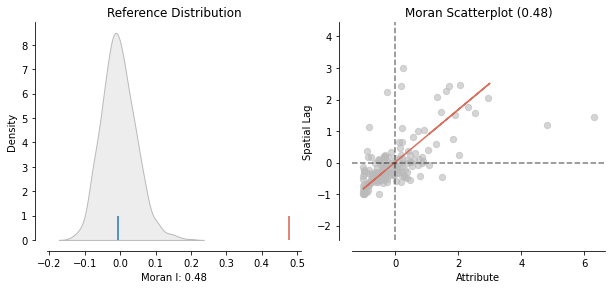

In [10]:
# YOUR CODE HERE
import libpysal
import splot
import esda
from splot.esda import plot_moran

# TODO Create spatial weights based on how the boundaries of our postal code areas touch each other. Create the weights based on the data GeoDataFrame using Queen contiguity 
# and store the resulting weights into a variable w. For creating the spatial weights, you can use the weights submodule from pysal library (see docs). If you need further information, 
# we also recommend checking chapter 4 from "Geographic Data Science with Python" book (Rey et al. forthcoming).
w = libpysal.weights.contiguity.Queen.from_dataframe(hr_gdf)

# TODO Drop possible islands (for the sake of simplicity we just ignore them in the analysis). You can get the index values of the islands from the weights by calling w.islands. 
# Then, reset the index of the GeoDataFrame, and recreate the weights using Queen contiguity (in a similar manner as in step 1)
hr_gdf_drop_islands = hr_gdf.drop(w.islands)
hr_gdf_drop_islands.reset_index(drop=True, inplace=True)
w = libpysal.weights.contiguity.Queen.from_dataframe(hr_gdf_drop_islands)

# TODO Row standardize the weights by using w.transform.
w.transform = 'r'
print(w.weights)
# TODO Answer to following questions by adding text after the Answer bullet point, below (hint: check the lecture materials/videos):

# Why do we need to create spatial weights? For what purpose are they for?
# Answer: 
# Spatial weights are values used to represent spatial relationships in a numerical format. It stores numerical values often in a matrix and it can be used to further analyze spatial relationships 
# between features. Different weightings such as inverse distance or contiguity can be applied for different types of analysis depending on the context. 

# What happens to the spatial weights after row standardization?
# Answer:
# After row standardization, the weights have been divided with the sum of elements on each row. This results in floating point numbers between 0 and 1 and all the row sums are equal to 1.

# Why is it important/good to row standardize spatial weights?
# Answer:
# 

# TODO Calculate the Moran's I based on the population density and using the spatial weights that we created in the previous step. For doing this, you can use the 
# Moran() function from the pysal library, which accepts the Series of our population density column as one parameter and the weights as another, check the pysal docs for details.
mi = esda.moran.Moran(hr_gdf_drop_islands["pop_density_km2"], w, two_tailed=False)

# TODO What is the global Moran's I for our data?
print("Moran's I: {:.5f}".format(mi.I))

# Create a Moran plot based on our data that allows us to investigate the spatial autocorrelation visually. For doing this, you can use a plot_moran() -function from pysal's splot submodule. Sanity check: if everything is correct Moran plot should produce something like following (Moran's I value is hidden):
plot_moran(mi)

# Answer to following questions by adding text after the Answer bullet points below (hint: check the lecture materials/videos):
# Based on the Moran's I, is there spatial autocorrelation in the data? Is it positive or negative?
# Answer:
# What does the result mean? I.e. describe what the spatial autocorrelation indicates in this case?
# Answer:
# Why is it important to understand whether your data is spatially autocorrelated (or not)?
# Answer:


## Problem 3 - Repeate the analysis for an attribute of your own interest (4 points)

Download the data from Statistics Finland into a GeoDataFrame using the `gpd.read_file()` function in a similar manner as was done in the Problem 1. Choose an attribute that interests you (there are plenty to choose from!), and repeat the spatial autocorrelation analysis in a similar manner as was done in Problem 2. You can also investigate other municipalities than the ones in Helsinki Region, if you wish (optional). Read the definitions and documentation for all attributes of the Statistical dataset from pages 5-7 in [this PDF file](https://www.stat.fi/static/media/uploads/tup/paavo/paavo_kuvaus_en.pdf).

Based on this analysis, describe whether your data is spatially autocorrelated or not: Write a short summary of your findings (few sentences).

In [3]:
# URL for postal code level data from Statistics Finland
url = "http://geo.stat.fi/geoserver/postialue/wfs?request=GetFeature&typename=postialue:pno_tilasto_2020&outputformat=JSON"

# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

## Problem 4 - How long did it take? Optional feedback (1 point)

To help developing the exercises, and understanding the time that it took for you to finish the Exercise, please provide an estimate of how many hours you spent for doing this exercise?

 - I spent approximately this many hours: **X hours**
 
In addition, if you would like to give any feedback about the exercise (optional), please provide it below:

 - My feedback: